In [231]:

import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
from gpytorch.distributions import MultivariateNormal

# Hack for relative imports of custom kernels
import sys
sys.path.insert(1, '..')
from kernels import *
import pdb
from itertools import product
import random
import configparser
import os

from sage.all import *
import sage
from sage.calculus.var import var
import time
import json
import pickle
from tqdm import tqdm, trange
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression, get_full_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import calculate_AIC, calculate_BIC, calculate_laplace
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib as mpl
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()

torch.manual_seed(42)

torch.set_default_dtype(torch.float64)

# Helper functions

In [232]:

def plot_model(description:str, NUM_TASKS:int, test_x, train_x, train_y, lower, upper, mean, ylim=[-30, 30], orig_data=None):
    """
    param description: 1. The key which is used to name the model as an svg file.
                       2. Naming of the plots (i.e. title) is based on this parameter
    """
    if NUM_TASKS == 5:
        f, (y1_ax, y2_ax, y3_ax, y4_ax, y5_ax) = plt.subplots(int(1), int(5), figsize=(int(15), int(4)))
    if NUM_TASKS == 4:
        f, (y1_ax, y2_ax, y3_ax, y4_ax) = plt.subplots(int(1), int(4), figsize=(int(15), int(4)))
    if NUM_TASKS == 3:
        f, (y1_ax, y2_ax, y3_ax) = plt.subplots(int(1), int(3), figsize=(int(15), int(4)))
    elif NUM_TASKS == 2:
        f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(15), int(4)))

    # Plot training data as black stars
    y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    if orig_data is not None:
        y1_ax.plot(train_x.numpy(), orig_data[:, 0].numpy(), 'r', alpha=float(0.6))
    # Shade in confidence
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    # y1_ax.set_ylim(ylim)
    y1_ax.legend(['Data', 'Mean', 'Original', 'Confidence'])
    y1_ax.set_title(description)

    # Plot training data as black stars
    y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    if orig_data is not None:
        y2_ax.plot(train_x.numpy(), orig_data[:, 1].numpy(), 'r', alpha=float(0.6))
    # Shade in confidence
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    # y2_ax.set_ylim(ylim)
    y2_ax.legend(['Mean', 'Original', 'Confidence'])
    y2_ax.set_title(description)

    if NUM_TASKS >= 3:
        # Plot training data as black stars
        y3_ax.plot(train_x.detach().numpy(), train_y[:, 2].detach().numpy(), 'k*')
        # Predictive mean as blue line
        y3_ax.plot(test_x.numpy(), mean[:, 2].numpy(), 'b')
        if orig_data is not None:
            y3_ax.plot(train_x.numpy(), orig_data[:, 2].numpy(), 'r', alpha=float(0.6))
        # Shade in confidence
        y3_ax.fill_between(test_x.numpy(), lower[:, 2].numpy(), upper[:, 2].numpy(), alpha=0.5)
        # y3_ax.set_ylim(ylim)
        y3_ax.legend(['Data', 'Mean', 'Original', 'Confidence'])
        y3_ax.set_title(description)

    if NUM_TASKS >=4:

        # Plot training data as black stars
        y4_ax.plot(train_x.detach().numpy(), train_y[:, 3].detach().numpy(), 'k*')
        # Predictive mean as blue line
        y4_ax.plot(test_x.numpy(), mean[:, 3].numpy(), 'b')
        if orig_data is not None:
            y4_ax.plot(train_x.numpy(), orig_data[:, 3].numpy(), 'r', alpha=float(0.6))
        # Shade in confidence
        y4_ax.fill_between(test_x.numpy(), lower[:, 3].numpy(), upper[:, 3].numpy(), alpha=0.5)
        y4_ax.set_ylim(ylim)
        y4_ax.legend(['Data', 'Mean', 'Original', 'Confidence'])
        y4_ax.set_title(description)

    if NUM_TASKS >=5:

        # Plot training data as black stars
        y5_ax.plot(train_x.detach().numpy(), train_y[:, 4].detach().numpy(), 'k*')
        # Predictive mean as blue line
        y5_ax.plot(test_x.numpy(), mean[:, 4].numpy(), 'b')
        if orig_data is not None:
            y5_ax.plot(train_x.numpy(), orig_data[:, 4].numpy(), 'r', alpha=float(0.6))
        # Shade in confidence
        y5_ax.fill_between(test_x.numpy(), lower[:, 4].numpy(), upper[:, 4].numpy(), alpha=0.5)
        y5_ax.set_ylim(ylim)
        y5_ax.legend(['Data', 'Mean', 'Original', 'Confidence'])
        y5_ax.set_title(description)
    return f

def calc_finite_differences(sample, point_step_size, skip=False, number_of_samples=0):
    """
    param skip: Decides whether to skip every second value of the sample.
                Useful for cases where original samples aren't equidistant
    """
    if sample.ndim == 2:
        NUM_CHANNELS = sample.shape[1]
    else:
        NUM_CHANNELS = 1
    if number_of_samples == 0:
        number_of_samples = sample.shape[0]

    gradients_list = list()
    if skip:
        step = 2
    for index in range(0, step*number_of_samples, step):
        gradients_list.append(list((-sample[index] + sample[index+1])/point_step_size))
    return gradients_list



       

def stack_plot_tensors(mean, lower, upper, num_tasks):
    indices = torch.tensor([i for i in range(0, len(mean), num_tasks)])
    zer = int(0)
    ind0 = indices
    ind1 = indices + int(1)
    ind2 = indices + int(2)
    ind3 = indices + int(3)
    #ind4 = indices + int(4)
    #mean = torch.stack((torch.index_select(mean, zer, ind0), torch.index_select(mean, zer, ind1), torch.index_select(mean, zer, ind2), torch.index_select(mean, zer, ind3), torch.index_select(mean, zer, ind4))).t()
    #lower = torch.stack((torch.index_select(lower, zer, ind0), torch.index_select(lower, zer, ind1), torch.index_select(lower, zer, ind2), torch.index_select(lower, zer, ind3), torch.index_select(lower, zer, ind4))).t()
    #upper = torch.stack((torch.index_select(upper, zer, ind0), torch.index_select(upper, zer, ind1), torch.index_select(upper, zer, ind2), torch.index_select(upper, zer, ind3), torch.index_select(upper, zer, ind4))).t()

    #mean = torch.stack((torch.index_select(mean, zer, ind0), torch.index_select(mean, zer, ind1))).t()
    #lower = torch.stack((torch.index_select(lower, zer, ind0), torch.index_select(lower, zer, ind1))).t()
    #upper = torch.stack((torch.index_select(upper, zer, ind0), torch.index_select(upper, zer, ind1))).t()

    mean = torch.stack((torch.index_select(mean, zer, ind0), torch.index_select(mean, zer, ind1), torch.index_select(mean, zer, ind2))).t()
    lower = torch.stack((torch.index_select(lower, zer, ind0), torch.index_select(lower, zer, ind1), torch.index_select(lower, zer, ind2))).t()
    upper = torch.stack((torch.index_select(upper, zer, ind0), torch.index_select(upper, zer, ind1), torch.index_select(upper, zer, ind2))).t()
    return mean, lower, upper


def symmetry_check(model):
    symmetry_check_matrix = model.matrix_multiplication - matrix([[cell.substitute(dx1=dx2, dx2=dx1) for cell in row] for row in model.matrix_multiplication.T]) #type: ignore
    # Symmetric up to numerical precision
    return all([all([cell < 1e-10 for cell in row]) for row in symmetry_check_matrix])

def eigval_check(model, train_x):
    covar_matrix = model(train_x).covariance_matrix
    eigvals = torch.linalg.eigh(covar_matrix)[0]
    compl_eigvals = torch.linalg.eig(covar_matrix)[0]
    return all([eig.real > -1e-10 for eig in eigvals]), all([eig.imag < 1e-10 for eig in compl_eigvals])


# GP Class

In [233]:


class LODEGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks, ODE_type="Bipendulum", noise_strategy=None):
        self.contains_nan = any(train_y.isnan().flatten())
        if self.contains_nan:
            train_y, self.mask = create_mask(train_y)
        super(LODEGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        # Put in front as they're either overwritten or used
        self.model_parameters = torch.nn.ParameterDict()
        R = QQ['x']; (x,) = R._first_ngens(1)
        if ODE_type == "Heating":
            #Heating system with parameters
            F = FunctionField(QQ, names=('a',)); (a,) = F._first_ngens(1)
            F = FunctionField(F, names=('b',)); (b,) = F._first_ngens(1)
            R = F['x']; (x,) = R._first_ngens(1)

            A = matrix(R, Integer(2), Integer(3), [x+a, -a, -1, -b, x+b, 0])
            self.model_parameters = torch.nn.ParameterDict({
                "a":torch.nn.Parameter(torch.tensor(0.0)),
                "b":torch.nn.Parameter(torch.tensor(0.0))
            })
        elif ODE_type == "Bipendulum":
            # Linearized bipendulum
            A = matrix(R, Integer(2), Integer(3), [x**2 + 9.81, 0, -1, 0, x**2+4.905, -1/2])
        elif ODE_type == "System 1":
            # System 1 (no idea)
            A = matrix(R, Integer(2), Integer(3), [x, -x**2+x-1, x-2, 2-x, x**2-x-1, -x])
        elif ODE_type == "Three Tank":
            # 3 Tank system (5 dimensional uncontrollable system)
            A = matrix(R, Integer(3), Integer(5), [-x, 0, 0, 1, 0, 0, -x, 0, 1, 1, 0, 0, -x, 0, 1])
        elif ODE_type == "Spring Mass":
            # Spring mass damper system, easy to control
            A = matrix(R, Integer(2), Integer(3), [-x, 1, 0, -1, -1-x, 1])
        elif ODE_type == "pos shifted sine":
            # sin
            A = matrix(R, Integer(1), Integer(1), [x^2 + 1])
        elif ODE_type == "neg shifted sine":
            # exp
            A = matrix(R, Integer(1), Integer(1), [x^2 - 1])

        D, U, V = A.smith_form()
        print(f"D:{D}")
        print(f"V:{V}")
        x, a, b = var("x, a, b")
        V_temp = [list(b) for b in V.rows()]
        print(V_temp)
        V = sage_eval(f"matrix({str(V_temp)})", locals={"x":x, "a":a, "b":b})
        Vt = V.transpose()
        kernel_matrix, self.kernel_translation_dict, parameter_dict = create_kernel_matrix_from_diagonal(D)
        self.ode_count = A.nrows()
        self.kernelsize = len(kernel_matrix)
        self.model_parameters.update(parameter_dict)
        print(self.model_parameters)
        var(["x", "dx1", "dx2"] + ["t1", "t2"] + [f"LODEGP_kernel_{i}" for i in range(len(kernel_matrix[Integer(0)]))])
        k = matrix(Integer(len(kernel_matrix)), Integer(len(kernel_matrix)), kernel_matrix)
        V = V.substitute(x=dx1) #type: ignore
        Vt = Vt.substitute(x=dx2) #type: ignore

        #train_x = self._slice_input(train_x)

        self.common_terms = {
            #"t_diff" : train_x-train_x.t(),

            "t_diff": train_x - train_x.unsqueeze(int(1)),
            "t_sum": train_x + train_x.unsqueeze(int(1)),
            #"t_sum" : train_x+train_x.t(),
            "t_ones": torch.ones_like(train_x + train_x.unsqueeze(int(1))),
            "t_zeroes": torch.zeros_like(train_x + train_x.unsqueeze(int(1)))
        }
        self.V = V
        self.matrix_multiplication = matrix(k.base_ring(), len(k[0]), len(k[0]), (V*k*Vt))
        self.diffed_kernel = differentiate_kernel_matrix(k, V, Vt, self.kernel_translation_dict)
        self.sum_diff_replaced = replace_sum_and_diff(self.diffed_kernel)
        self.covar_description = translate_kernel_matrix_to_gpytorch_kernel(self.sum_diff_replaced, self.model_parameters, common_terms=self.common_terms)
        self.covar_module = LODE_Kernel(self.covar_description, self.model_parameters)


    def forward(self, X):
        if not torch.equal(X, self.train_inputs[0]):
            self.common_terms["t_diff"] = X-X.t()
            self.common_terms["t_sum"] = X+X.t()
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X, common_terms=self.common_terms)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [234]:

def log_prior(model, theta_mu=None, sigma=None):
    theta_mu = [float(0.) for _ in model.parameters()]
    variances_list = [float(7.) for _ in model.parameters()]
    params = [p.item() for p in model.parameters()]
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(int(0)).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    sigma = sigma@sigma
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    # for convention reasons I'm diving by the number of datapoints
    return prior.log_prob(torch.Tensor(params)).item() / len(*model.train_inputs)



def random_reinit(model):
    for param in model.parameters():
        new_param_value = torch.randn_like(param)
        param.data = new_param_value



def optimize_hyperparameters(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    line_search = kwargs.get("line_search", False)
    BFGS_iter = kwargs.get("BFGS_iter", 50)
    train_iterations = kwargs.get("train_iterations", 0)
    X = kwargs.get("X", model.train_inputs)
    Y = kwargs.get("Y", model.train_targets)
    with_BFGS = kwargs.get("with_BFGS", False)
    history_size = kwargs.get("history_size", 100)
    MAP = kwargs.get("MAP", True)
    prior = kwargs.get("prior", False)
    granso = kwargs.get("granso", True)

    if log_likelihood:
        likelihood_log = list()
        best_likelihood_log = likelihood_log
    if log_param_path:
        param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}
        for param_name in model.named_parameters():
            param_log_dict[param_name[0]].append(param_name[1].item())
        best_param_log_dict = param_log_dict


    mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = -mll(model(X), Y)
    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()
    

    for restart in range(random_restarts):
        try:
            #optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
            #mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)
            ## Train the ADAM part
            #for _ in range(train_iterations):
            #    optimizer.zero_grad()
            #    output = model(X)
            #    loss = -mll(output, Y)
            #    if MAP:
            #        log_p = log_prior(model)
            #        loss -= log_p
            #    loss.backward()
            #    optimizer.step()
            #    if log_param_path:
            #        for param_name in model.named_parameters():
            #            param_log_dict[param_name[0]].append(param_name[1].item())
            #    if log_likelihood:
            #        likelihood_log.append(loss.item())
            ## Train the L-BFGS part
            #if with_BFGS:
            #    optimizer = torch.optim.LBFGS(model.parameters(), history_size=history_size, max_iter=BFGS_iter, line_search_fn=None if not line_search else "strong_wolfe")
            #    def closure():
            #        optimizer.zero_grad()
            #        output = model(X)
            #        loss = -mll(output, Y)
            #        if MAP:
            #            log_p = log_prior(model)
            #            loss -= log_p
            #        loss.backward()
            #        return loss
            #    loss = optimizer.step(closure)
            if granso:
                print("I USE GRANSO")
                # Set up the PyGRANSO optimizer
                opts = pygransoStruct()
                opts.torch_device = torch.device('cpu')
                nvar = getNvarTorch(model.parameters())
                opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
                opts.opt_tol = 1e-10
                opts.limited_mem_size = 100
                opts.globalAD = True
                opts.quadprog_info_msg = False
                opts.print_level = 0
                opts.halt_on_linesearch_bracket = False

                # Define the objective function
                def objective_function(model):
                    output = model(X)
                    loss = -mll(output, Y)
                    if MAP:
                        log_p = log_prior(model)
                        loss -= log_p
                    print(loss)
                    return [loss, None, None]

                print(f"pre training: {list(model.named_parameters())} w. loss: {objective_function(model)[0]}")
                # Train the model using PyGRANSO
                soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
                print(f"post training: {list(model.named_parameters())} w. loss: {soln.final.f}")
                print(f"post training: {list(model.named_parameters())} w. loss: {soln.best.f}")

            # I can't log using the closure since it's called too often when using line search
            if log_param_path:
                if with_BFGS:
                    for param_num, param_name in enumerate(model.named_parameters()):
                        if len(optimizer.state_dict()["state"]) > 1:
                            pdb.set_trace()
                        for step in optimizer.state_dict()["state"][0]["old_stps"]:
                            param_log_dict[param_name[0]].append(param_log_dict[param_name[0]][-1] + step[param_num])
            if log_likelihood:
                likelihood_log.append(loss.item())
            #if loss < best_loss:
            #    best_loss = loss
            #    best_model_state_dict = model.state_dict()
            #    best_likelihood_state_dict = likelihood.state_dict()
            #    if any([log_likelihood, log_param_path]):
            #        if log_likelihood:
            #            best_likelihood_log = likelihood_log 
            #            likelihood_log = list()
            #        if log_param_path:
            #            best_param_log_dict = param_log_dict
            #            param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}
        # Training blew up
        except Exception as E:
            random_reinit(model)
            pass 
        # print output if enabled
        if options["training"]["print_optimizing_output"]:
            print(f"HYPERPARAMETER OPTIMIZATION: Random Restart {restart}: loss: {loss}, optimal loss: {best_loss}")
        random_reinit(model)
    #model.load_state_dict(best_model_state_dict)
    #likelihood.load_state_dict(best_likelihood_state_dict)

    # Zero gradients from previous iteration
    #optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    if MAP:
        log_p = log_prior(model)
        loss -= log_p
    if any([log_likelihood, log_param_path]):
        logables = dict()
        if log_likelihood:
            logables["log_likelihood"] = best_likelihood_log
        if log_param_path:
            logables["log_param_path"] = best_param_log_dict
        return loss, logables, model, likelihood
    else:
        return loss, model, likelihood




# Define the training loop
def optimize_hyperparameters2(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    line_search = kwargs.get("line_search", False)
    BFGS_iter = kwargs.get("BFGS_iter", 50)
    train_iterations = kwargs.get("train_iterations", 0)
    train_x = kwargs.get("X", model.train_inputs)
    train_y = kwargs.get("Y", model.train_targets)
    with_BFGS = kwargs.get("with_BFGS", False)
    history_size = kwargs.get("history_size", 100)
    MAP = kwargs.get("MAP", True)
    prior = kwargs.get("prior", False)
    granso = kwargs.get("granso", True)

    # Set up the likelihood and model
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    #model = GPModel(train_x, train_y, likelihood)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = float(1e-10)
    opts.limited_mem_size = int(100)
    opts.globalAD = True
    opts.quadprog_info_msg = False
    opts.print_level = int(0)
    opts.halt_on_linesearch_bracket = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        loss = -mll(output, train_y)
        log_p = log_prior(model)
        loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = int(5)
    best_f = np.inf
    for restart in range(random_restarts):
        print(f"pre training parameters: {list(model.named_parameters())}")
        # Train the model using PyGRANSO
        soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f} (smaller=better)")
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)

    loss = -mll(model(train_x), train_y)
    log_p = log_prior(model)
    loss -= log_p

    print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    
    print(torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True))
    # Return the trained model
    return loss, model, likelihood


def get_std_points(mu, K):
    x, y = np.mgrid[float(-3):float(3):float(.1), float(-3):float(3):float(.1)]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = int(50)
    unit_x = torch.cat([torch.linspace(float(-1), float(1), precision), torch.linspace(float(-1), float(1), precision)])
    unit_y = torch.cat([torch.sqrt(float(1) - torch.linspace(float(-1), float(1), precision)**float(2)), -torch.sqrt(float(1) - torch.linspace(float(-1), float(1), precision)**float(2))])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + float(2)*res[0])
        new_unit_y.append(mu[1] + float(2)*res[1])
    return new_unit_x, new_unit_y


In [235]:
figure_path = "LODE_grad_figures"

# Data

satisfying x^2 - 1 = 0: -5.638457211986263
satisfying x^2 + 1 = 0: 0.011606525551672159


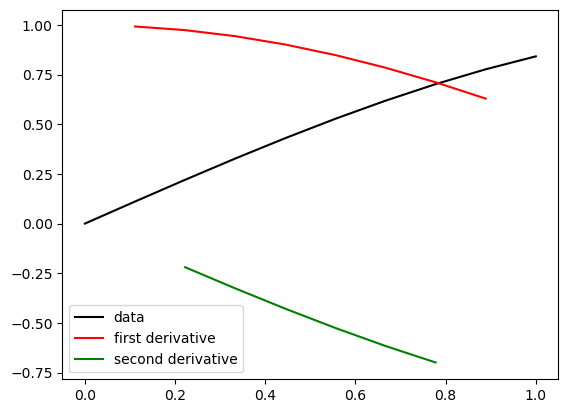

In [236]:
# 1.) sinusoidal data is scaled, but the kernel is not. Fix that scaling by pi!
# 2) Something about the exp. kernel is wrong. Check the satisfaction of the differential equation numerically at several stages
# 2.1 Does the data satisfy the differential equation? YES, up to 1e-2 at least, which is ok-ish, given I have to approximate a 2nd derivative
# 2.2 Does the cov. matrix satisfy the differential equation? YES
# 2.3 Does the mean satisfy the differential equation? YES

# Oh and also: Draw the posterior instead of the likelihood in your MCMC plots
# i.e. multiply with the prior at these points, as this is more true to what MCMC is doing
COUNT = int(10)
train_x = torch.linspace(int(0), int(1), COUNT)
#dataset_name="exp"
#train_y = torch.exp(train_x)
#dataset_name="exp + exp"
#train_y = torch.exp(train_x) + float(1.0)*torch.exp(-train_x)

dataset_name="sin"
train_y = torch.sin(train_x*float(1.0))
#dataset_name="none"
#train_y = torch.exp(train_x) + torch.sin(train_x)


# approximative first derivative
derivative = torch.gradient(train_y, spacing=(train_x,))
snd_deriv = torch.gradient(derivative[0], spacing=(train_x,))
print(f"satisfying x^2 - 1 = 0: {torch.sum(snd_deriv[0][2:-2] - train_y[2:-2])}")
print(f"satisfying x^2 + 1 = 0: {torch.sum(snd_deriv[0][2:-2] + train_y[2:-2])}")
#x^2 - 1

plt.plot(train_x, train_y, c="black")
plt.plot(train_x[1:-1], derivative[0][1:-1], c="red")
plt.plot(train_x[2:-2], snd_deriv[0][2:-2], c="green")
plt.legend(["data", "first derivative", "second derivative"])
tikzplotlib.save(f"{figure_path}/data_{dataset_name}.tex")
plt.savefig(f"{figure_path}/data_{dataset_name}.png")

In [237]:
train_x-train_x.t()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Model definition

In [238]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(1))
# Has solution c_1 exp(x) + c_2 exp(-x)
#model_name = "exp + exp"
#model = LODEGP(train_x, train_y, likelihood, int(1), "neg shifted sine")
# Has solution sin(x)
model_name = "sin"
model = LODEGP(train_x, train_y, likelihood, int(1), "pos shifted sine")

# ODE test neg shifted sine
model.diffed_kernel#[0][0].diff(t1, 2) - model.diffed_kernel[0][0]
# ODE test pos shifted sine
#model.diffed_kernel[0][0].diff(t1, 2) + model.diffed_kernel[0][0]

D:[x^2 + 1]
V:[1]
[[1]]
ParameterDict(  (signal_variance_0_0): Parameter containing: [torch.DoubleTensor of size ])


[[signal_variance_0_0^2*cos(-1.0*t1 + 1.0*t2)]]

In [239]:
model.V 
model.matrix_multiplication 
model.diffed_kernel
model.sum_diff_replaced 
model.covar_description
#model.covar_module

[[<code object <module> at 0x7fe69a740be0, file "", line 1>]]

k[0]: tensor([1.0000, 0.9938, 0.9754, 0.9450, 0.9028, 0.8496, 0.7859, 0.7125, 0.6303,
        0.5403], grad_fn=<SelectBackward0>)
mean: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cov. satisfying x^2 - 1 = 0: -10.321126695941878
cov. satisfying x^2 + 1 = 0: 0.021245602514079143
mu. satisfying x^2 - 1 = 0: 0.0
mu. satisfying x^2 + 1 = 0: 0.0


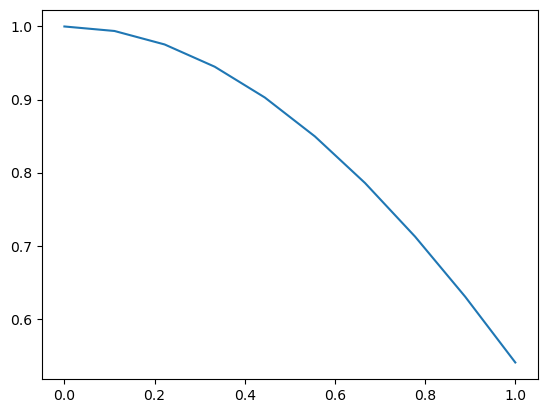

In [240]:
mu = model(train_x).mean.flatten()
k_0 = model(train_x).covariance_matrix[:,0].flatten()
print(f"k[0]: {k_0}")
grad1 = torch.gradient(k_0, spacing=(train_x,))[0]
grad2 = torch.gradient(grad1, spacing=(train_x,))[0]
print(f"mean: {mu}")
mu_grad1 = torch.gradient(mu, spacing=(train_x,))[0]
mu_grad2 = torch.gradient(mu_grad1, spacing=(train_x,))[0]

print(f"cov. satisfying x^2 - 1 = 0: {torch.sum(grad2[2:-2] - k_0[2:-2])}")
print(f"cov. satisfying x^2 + 1 = 0: {torch.sum(grad2[2:-2] + k_0[2:-2])}")
print(f"mu. satisfying x^2 - 1 = 0: {torch.sum(mu_grad2[2:-2] - mu[2:-2])}")
print(f"mu. satisfying x^2 + 1 = 0: {torch.sum(mu_grad2[2:-2] + mu[2:-2])}")

plt.plot(train_x, k_0.detach().numpy())


# Training

In [241]:
num_train_iter = 0
use_MAP = True 
use_LBFGS = False
LBFGS_iter = 50
# Train the MAP for 100 Iterations of ADAM and then 50 more of L-BFGS
loss, model, likelihood = optimize_hyperparameters2(model, likelihood,
                                                    X=train_x, 
                                                    Y=train_y
                                                   )
#loss,  model, likelihood = optimize_hyperparameters(model, likelihood, 
#                                                                 line_search=False, 
#                                                                 X=train_x, 
#                                                                 Y=train_y, 
#                                                                 train_iterations=0, 
#                                                                 #BFGS_iter=LBFGS_iter, 
#                                                                 #history_size=2*LBFGS_iter, 
#                                                                 #with_BFGS=use_LBFGS, 
#                                                                 #MAP=use_MAP, 
#                                                                 log_param_path=False, 
#                                                                 random_restarts=1, 
#                                                                 log_likelihood=False)


pre training parameters: [('likelihood.raw_task_noises', Parameter containing:
tensor([0.], requires_grad=True)), ('likelihood.raw_noise', Parameter containing:
tensor([0.], requires_grad=True)), ('model_parameters.signal_variance_0_0', Parameter containing:
tensor(0., requires_grad=True))]
post training (final): [('likelihood.raw_task_noises', Parameter containing:
tensor([-20.4297], requires_grad=True)), ('likelihood.raw_noise', Parameter containing:
tensor([-20.4297], requires_grad=True)), ('model_parameters.signal_variance_0_0', Parameter containing:
tensor(-0.3469, requires_grad=True))] w. loss: -0.6379158697048188 (smaller=better)
pre training parameters: [('likelihood.raw_task_noises', Parameter containing:
tensor([0.3367], requires_grad=True)), ('likelihood.raw_noise', Parameter containing:
tensor([0.1288], requires_grad=True)), ('model_parameters.signal_variance_0_0', Parameter containing:
tensor(0.2345, requires_grad=True))]
post training (final): [('likelihood.raw_task_noise

In [242]:
list(model.named_parameters())

[('likelihood.raw_task_noises',
  Parameter containing:
  tensor([-20.4297], requires_grad=True)),
 ('likelihood.raw_noise',
  Parameter containing:
  tensor([-20.4297], requires_grad=True)),
 ('model_parameters.signal_variance_0_0',
  Parameter containing:
  tensor(-0.3469, requires_grad=True))]

In [243]:
model.train()
likelihood.train()
mu = likelihood(model(train_x)).mean.flatten()
k_0 = likelihood(model(train_x)).covariance_matrix[0]
print(f"k[0]: {k_0}")
grad1 = torch.gradient(k_0, spacing=(train_x,))[0]
grad2 = torch.gradient(grad1, spacing=(train_x,))[0]
print(f"mean: {mu}")
mu_grad1 = torch.gradient(mu, spacing=(train_x,))[0]
mu_grad2 = torch.gradient(mu_grad1, spacing=(train_x,))[0]

print(f"cov. satisfying x^2 - 1 = 0: {torch.sum(grad2[2:-2] - k_0[2:-2])}")
print(f"cov. satisfying x^2 + 1 = 0: {torch.sum(grad2[2:-2] + k_0[2:-2])}")
print(f"mu. satisfying x^2 - 1 = 0: {torch.sum(mu_grad2[2:-2] - mu[2:-2])}")
print(f"mu. satisfying x^2 + 1 = 0: {torch.sum(mu_grad2[2:-2] + mu[2:-2])}")

k[0]: tensor([0.4999, 0.4966, 0.4874, 0.4722, 0.4511, 0.4245, 0.3927, 0.3560, 0.3149,
        0.2700], grad_fn=<SelectBackward0>)
mean: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cov. satisfying x^2 - 1 = 0: -5.153370196668181
cov. satisfying x^2 + 1 = 0: 0.014666385543073146
mu. satisfying x^2 - 1 = 0: 0.0
mu. satisfying x^2 + 1 = 0: 0.0


In [244]:
model(train_x).mean

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

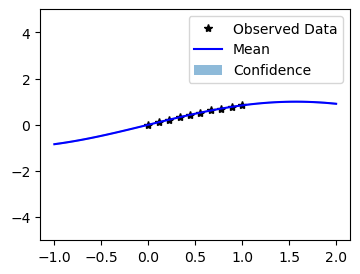

In [245]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-1), float(2), int(51))
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.flatten().numpy(), upper.flatten().numpy(), alpha=float(0.5))
    ax.set_ylim([-5, 5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_posterior.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_posterior.tex")

# Lap

In [246]:
#print(f"L-BFGS iterations: {len(training_log['log_likelihood']) - num_train_iter}")
model.train()
likelihood.train()
punish_term = "BIC"
lap_approx_S, lap_log_S = metrics.calculate_laplace(model, -loss*model.train_targets.numel(), with_prior=True, param_punish_term=float(0.0))
lap_approx_AIC, lap_log_AIC = metrics.calculate_laplace(model, -loss*model.train_targets.numel(), with_prior=True, param_punish_term=float(-1.0))
lap_approx_BIC, lap_log_BIC = metrics.calculate_laplace(model, -loss*model.train_targets.numel(), with_prior=True, param_punish_term="BIC")
print(lap_approx_S)
print(lap_log_S)
print(lap_approx_AIC)
print(lap_log_AIC)
print(lap_approx_BIC)
print(lap_log_BIC)

# Draw the distribution defined by the mean (found parametrization) and covariance matrix (Hessian)
# (4.133) in Bishop, 2006: f(z) ~ f(z_0)exp(-0.5 (z-z_0)^T H (z-z_0)) with z the parameters, and H the Hessian
# We just leave out the f(z_0)

#scaling_factor = lap_log["neg MLL"]
#mu = [p.item() for p in list(model.parameters())]
##mu = [training_log["log_param_path"][param_keys[0]][-1], training_log["log_param_path"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

trained_mu = [p.item() for p in list(model.parameters())]

tensor(5.4601, dtype=torch.float64, grad_fn=<AddBackward0>)
{'neg MLL': tensor(-6.3792, dtype=torch.float64, grad_fn=<NegBackward0>), 'punish term': tensor(-0.9190, dtype=torch.float64), 'laplace without replacement': tensor(18.0503, dtype=torch.float64, grad_fn=<SubBackward0>), 'num_replaced': tensor(3), 'parameter list': ['likelihood.raw_task_noises', 'likelihood.raw_noise'], 'Jacobian': (tensor([2.6824e-05], dtype=torch.float64, grad_fn=<SoftplusBackwardBackward0>), tensor([2.6824e-05], dtype=torch.float64, grad_fn=<SoftplusBackwardBackward0>), tensor(-0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)), 'parameter values': tensor([[-20.4297],
        [-20.4297],
        [ -0.3469]], dtype=torch.float64), 'corrected Hessian': tensor([[ 6.2832e+00, -1.3191e-15,  3.4891e-17],
        [-1.7631e-15,  6.2832e+00, -2.1131e-15],
        [ 3.4891e-17, -2.1131e-15,  6.2832e+00]], dtype=torch.float64), 'diag(constructed eigvals)': tensor([6.2832, 6.2832, 6.2832], dtype=torch.float64), 'orig

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for i, val in enumerate(vals)]))


# AIC / BIC

In [247]:
AIC_approx , AIC_log = calculate_AIC(-loss*len(train_x), len(trained_mu))
print(AIC_approx)
print(AIC_log)

tensor(6.7583, dtype=torch.float64, grad_fn=<AddBackward0>)
{'punish term': 6, 'Total time': 6.842613220214844e-05, 'loss term': tensor(12.7583, dtype=torch.float64, grad_fn=<MulBackward0>)}


In [248]:
BIC_approx , BIC_log = calculate_BIC(-loss*len(train_x), len(trained_mu), torch.tensor(len(train_x)))
print(BIC_approx)
print(BIC_log)

tensor(5.8506, dtype=torch.float64, grad_fn=<AddBackward0>)
{'punish term': tensor(-6.9078), 'Total time': 0.00017452239990234375, 'loss term': tensor(12.7583, dtype=torch.float64, grad_fn=<MulBackward0>)}


# STAN functions

In [249]:
def generate_STAN_LODE_kernel(LODE_type = "pos shifted sine"):
    """
    parameter_list : We assume it just contains strings of parameter names
    """
    if LODE_type == "neg shifted sine":
        kernel_representation = "exp(theta[4])^2 .* exp(t_sum) + exp(theta[3])^2 .* exp(-t_sum)"
    elif LODE_type == "pos shifted sine":
        kernel_representation = "exp(theta[3])^2 .* cos(t_diff)"
    STAN_str_kernel = f"(identity_matrix(dims(x)[1]).*1e-10) + (identity_matrix(dims(x)[1]).*softplus(theta[1])) + (identity_matrix(dims(x)[1]).*softplus(theta[2])) + {kernel_representation}"
    return STAN_str_kernel


def generate_STAN_code(LODE_type = "pos shifted sine"):
    # Alternative: use 1:dims(v)[0] in the loop
    functions = """
    functions {
        array[] real softplus(array[] real v){
            array[num_elements(v)] real r;
            for (d in 1:num_elements(v)){
                r[d] = log1p(exp(v[d]));
            }
            return r;
        }
        real softplus(real v){
            return log1p(exp(v));
        }
    }
    """


    data = """
    data {
        int N;
        int D;
        array[N] real x;
        vector[N] y;
        vector[D] t_mu;
        matrix[D, D] t_sigma;
    }
    """

    # Old version:
    #vector<lower=-9.2102>[D] theta_tilde;
    # Give it lower bound -3.0 for each parameter to ensure Softplus doesn't reach 0
    parameters = """
    parameters {
        vector<lower=-30>[D] theta;
    }
    """
    transformed_parameters = f"""
        transformed parameters {{
            vector[D] theta;
            if(theta_tilde[1] < -30.2102){{
                theta[1] = -30.2102;
            }}else{{
                theta[1] = theta_tilde[1];
            }}
            for(i in 2:D){{
                theta[i] = theta_tilde[i];
            }}
            
        }}
    """
    #t_diff = -temp + temp2;
    #t_sum = temp + temp2';
    # -x(j) oder -x(k)?
    model = f"""
    model {{
        matrix[N, N] K;
        vector[N] mu;
        theta ~ multi_normal(t_mu, t_sigma);
        matrix[N, N] t_diff;
        matrix[N, N] t_sum;
        for(j in 1:N){{
            for(k in 1:N){{
                t_diff[j,k] = -x[j] + x[k];   
                t_sum[j,k] = x[j] + x[k];
            }}
        }}
        K = {generate_STAN_LODE_kernel(LODE_type=LODE_type)};
        mu = zeros_vector(N);
        y ~ multi_normal(mu, K);
    }}
    """

    generated_quantities = f"""
    generated quantities {{
        real lpd;
        matrix[N, N] K;
        vector[N] mu;
        K = {generate_STAN_LODE_kernel()};
        mu = zeros_vector(N);
        lpd = multi_normal_lpdf(y | mu, K);
    }}
    """
    code = functions + data + parameters +model#transformed_parameters+ model #+ generated_quantities
    return code

    
def calculate_mc_STAN(model, likelihood, num_draws, **kwargs):
    print("START")
    logables = dict()
    # Grab variables from kwargs
    log_param_path = kwargs.get("log_param_path", False)    
    log_full_likelihood = kwargs.get("log_full_likelihood", False)
    log_full_posterior = kwargs.get("log_full_posterior", True)

    theta_mu = [float(0.) for _ in model.parameters()]
    variances_list = [float(7.) for _ in model.parameters()]
    params = [p.item() for p in model.parameters()]
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(int(0)).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    sigma = sigma@sigma
    print("PRIOR")

    if model_name == "exp + exp":
        STAN_code = generate_STAN_code("neg shifted sine")
    if model_name == "sin":
        STAN_code = generate_STAN_code("pos shifted sine")
    print("STAN GENERATED")
    # Required data for the STAN model:
    """
    int N;
    int D;
    array[N] real x;
    vector[N] y;
    vector[D] t_mu;
    cov_matrix[D, D] t_sigma;
    """
    if type(model.train_inputs) == tuple:
        x = model.train_inputs[0].tolist()
        # Assuming I have [[x1], [x2], [x3], ...]
        if not np.ndim(x) == 1:
            x = [t[0] for t in x]
    else:
        x = model.train_inputs.tolist()
    STAN_data = {"N" : len(x),
                 "D" : len(theta_mu),
                 "x" : x,
                 "y" : model.train_targets.tolist(),
                 "t_mu" : [t[0] for t in theta_mu.tolist()],
                 "t_sigma" : sigma.tolist()
    }
    #print("========================")
    #print("data")
    #print(STAN_data)
    #print("Code")
    #print(STAN_code)
    #print("========================")
    start = time.time()
    seed = random.randint(0, 1000000)
    #print(STAN_data)
    #print(STAN_code)
    posterior = stan.build(STAN_code, data=STAN_data, random_seed=seed)
    end = time.time()
    STAN_model_generation_time = end - start
    if num_draws is None:
       raise("Number of draws not specified")
    start = time.time()

    fit = posterior.sample(num_chains=int(1), num_samples=num_draws)#, num_warmup=int(1))
    end = time.time()
    STAN_MCMC_sampling_time = end - start
    # Use the sampled parameters to reconstruct the mean and cov. matr.
    # Average(?) to get the actual posterior likelihood
    post_frame = fit.to_frame()
    import pdb
    #pdb.set_trace()
    #print(fit)
    manual_lp_list = list()
    manual_post_list = list()
    log_prior_list = list()
    bad_entries = 0

    def inv_softplus(x):
        return x + torch.log(-torch.expm1(-x))

    start = time.time()
    STAN_like_approx = post_frame["lp__"]
    # Iterate over chain
    for row_num, sample in enumerate(post_frame[list(fit.constrained_param_names)].iterrows()):
        # Iterate over kernel parameters
        # Main assumption: Kernel parameters are stored in order of kernel
        # appearance from left to right, just like in STAN
        # Each theta corresponds to exactly one model parameter
        for model_param, sampled_param in zip(model.parameters(), sample[1]):
            #model_param.data = torch.full_like(model_param.data, inv_softplus(torch.tensor(sampled_param)))
            model_param.data = torch.full_like(model_param.data, torch.tensor(sampled_param))


        try:
            with torch.no_grad():
                observed_pred_prior = likelihood(model(model.train_inputs[0]))
            #pdb.set_trace()

            like_cov_chol = torch.linalg.cholesky(observed_pred_prior.covariance_matrix)
            like_dist = torch.distributions.multivariate_normal.MultivariateNormal(observed_pred_prior.mean.flatten(), scale_tril=like_cov_chol)
            manual_lp_list.append(like_dist.log_prob(model.train_targets))
            manual_post_list.append(like_dist.log_prob(model.train_targets) + log_prior(model))
            log_prior_list.append(log_prior(model))
        except Exception as e:
            manual_lp_list.append(np.nan)
            bad_entries += 1
            print(e)
            print(list(model.named_parameters()))
            #print(torch.linalg.eig(like_cov_matr.evaluate()))


    parameter_statistics = {
        p: {"mu": np.mean(post_frame[list(fit.constrained_param_names)][p]), 
            "var": np.var(post_frame[list(fit.constrained_param_names)][p])}
                for p in post_frame[list(fit.constrained_param_names)]}

    end = time.time()
    likelihood_approximation_time = end - start
    #total_time = end - total_start

    logables["Kernel code"] = STAN_code
    logables["seed"] = seed
    logables["Likelihood time"] = likelihood_approximation_time
    logables["Model compile time"] = STAN_model_generation_time
    logables["Sampling time"] = STAN_MCMC_sampling_time
    logables["Bad entries"] = bad_entries
    logables["Parameter statistics"] = parameter_statistics
    logables["Parameter prior"] = {"mu":theta_mu, "var": sigma} 
    logables["likelihood approximation"] = torch.nanmean(torch.Tensor(manual_lp_list))
    logables["posterior approximation"] = torch.nanmean(torch.Tensor(manual_post_list))
    logables["STAN_like_approx"] = STAN_like_approx
    logables["log prior list"] = log_prior_list
    if log_full_posterior:
        logables["manual post list"] = manual_post_list
    if log_full_likelihood:
        logables["manual lp list"] = manual_lp_list
    if log_param_path:
        logables["param draws dict"] = post_frame[list(fit.constrained_param_names)]
    ##print(f"Num bad entries: {bad_entries}")
    return torch.nanmean(torch.Tensor(manual_lp_list)), logables

# MCMC

In [250]:
MCMC_approx, MC_log = calculate_mc_STAN(model, likelihood, int(1000), log_param_path=True, log_full_likelihood=True, log_full_posterior=True)


START
PRIOR
STAN GENERATED
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_2fpbv6p1/model_m4vbzgse.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_2fpbv6p1/model_m4vbzgse.stan', line 40, column 90 to
    column 98, the value of v depends on parameter(s): theta.
Warning in '/tmp/httpstan_2fpbv6p1/model_m4vbzgse.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_2fpbv6p1/model_m4vbzgse.stan', line 40, column 142 to
    column 150, the value of v depends on parameter(s): theta.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  45% (900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 1

In [ ]:
import scipy.stats as stats

def is_inside_2sigma(point, mean, std):
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    return stats.norm.cdf(point, mean, std) >= stats.norm.cdf(lower_bound, mean, std) and \
           stats.norm.cdf(point, mean, std) <= stats.norm.cdf(upper_bound, mean, std)


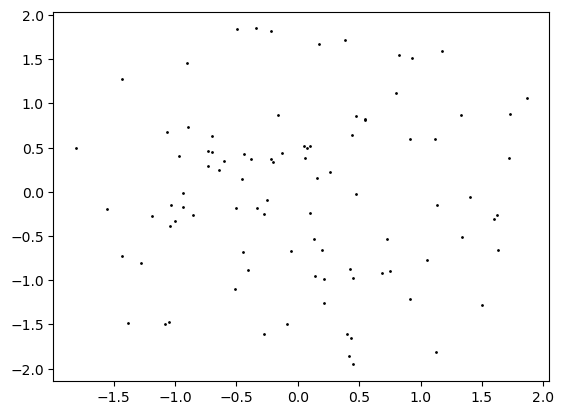

In [286]:
import numpy as np
import scipy.stats as stats

def generate_2sigma_points(mean, cov, num_points):
    # Generate random points from a multivariate normal distribution
    points = np.random.multivariate_normal(mean, cov, num_points)
    
    # Calculate the standard deviation
    std = np.sqrt(np.diag(cov))
    
    # Calculate the 2 sigma boundary
    boundary = mean + 2 * std
    
    # Filter the points lying on the 2 sigma boundary
    boundary_points = []
    for point in points:
        if np.all(point <= boundary) and np.all(point >= -boundary):
            boundary_points.append(point)
    
    return np.array(boundary_points)

#sigma2_points = generate_2sigma_points([float(0.), float(0.)], np.diag([float(1.), float(1.)]), int(100))
plt.plot(sigma2_points[:,0], sigma2_points[:,1], "o", color="black", markersize=1)

In [296]:
from sage.stats.distributions.mv_normal import MultivariateNormalDistribution

def generate_2sigma_points(mean, cov, num_points):
    # Create a multivariate normal distribution
    dist = MultivariateNormalDistribution(mean, cov)
    
    # Calculate the standard deviation
    std = cov.sqrt().diagonal()
    
    # Calculate the 2 sigma boundary
    boundary = mean + 2 * std
    
    # Generate points exactly on the 2 sigma boundary
    points = []
    for i in range(num_points):
        point = None
        while point is None or not all(point[j] == boundary[j] or point[j] == -boundary[j] for j in range(len(mean))):
            point = dist.random_element()
        points.append(point)
    
    return points


Type:            module
String form:     <module 'sage.stats.distributions' from '/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/sage/stats/distributions/__init__.py'>
File:            ~/anaconda3/envs/sage/lib/python3.10/site-packages/sage/stats/distributions/__init__.py
Docstring:       Initialize self.  See help(type(self)) for accurate signature.
Class docstring:
Create a module object.

The name must be a string; the optional doc argument can have any
type.
Init docstring:  Initialize self.  See help(type(self)) for accurate signature.


In [317]:
import scipy
my_cov = [float(1.) for i in range(10)]
my_cov[0] = float(4.)
my_dist = scipy.stats.multivariate_normal([float(0.) for i in range(10)], np.diag(my_cov))
my_dist.cdf([float(0.) for i in range(10)])
my_matr = [float(0.) for i in range(10)]
my_matr[0] = float(-2.)
my_dist.cdf(my_matr)



# Calculate the cdf of 2*sigma and -2*sigma
# Iterate over each point in the sample list and check whether it is inside the lower and upper bound given by -2*sigma and 2*sigma





0.000309873542834877

In [275]:
import shapely.geometry as geom
mu = torch.tensor(trained_mu)
for lap_type in [lap_log_S, lap_log_AIC, lap_log_BIC]:
    K = lap_type["corrected Hessian"]
    new_unit_x, new_unit_y = get_std_points(mu, K.inverse())
#
#    ellipse = geom.Polygon(xy)
#    for p in points:
#        if ellipse.contains(geom.Point(p)):
#            print(p)
#            print("is inside")

ValueError: operands could not be broadcast together with shapes (60,60,2) (3,) 

In [270]:
import scipy.stats as stats
my_dist = stats.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
my_dist.cdf(torch.tensor([float(10.), float(0.)])) <= my_dist.cdf(my_dist.)

AttributeError: 'multivariate_normal_frozen' object has no attribute 'std'

# MC Figures

/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/tikzplotlib/_axes.py:12: MatplotlibDeprecationWarning: The common_texification function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  return mpl_common_texification(string).replace("&", "\\&")
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/tikzplotlib/_util.py:15: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  keys = [h.get_label() for h in leg.legendHandles if h is not None]


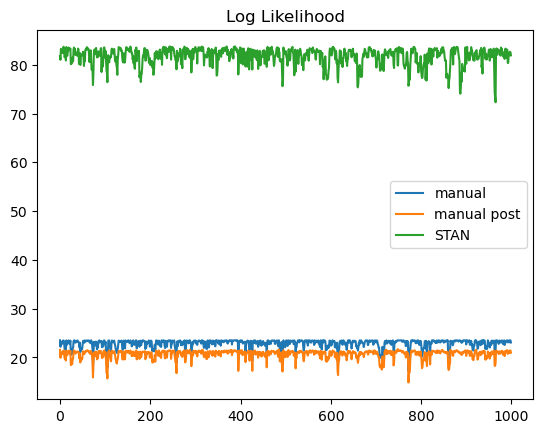

In [251]:
plt.plot(MC_log['manual lp list'])
plt.plot(MC_log["manual post list"])
plt.plot(MC_log["STAN_like_approx"])
plt.legend(["manual", "manual post", "STAN"])
plt.title("Log Likelihood")
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_log_likelihood_MCMC_draws.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_log_likelihood_MCMC_draws.tex")

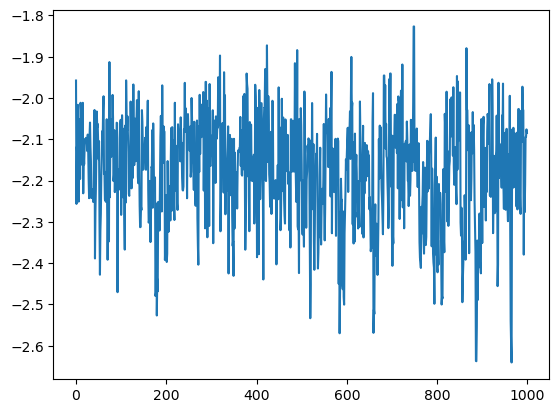

In [252]:
plt.plot(MC_log["log prior list"])

{'theta.1': {'mu': -25.25941652422582, 'var': 2.5080085664166964},
 'theta.2': {'mu': -25.420415426391898, 'var': 2.647072305582835},
 'theta.3': {'mu': 0.029624441417210313, 'var': 0.45555638517682157}}
{'mu': tensor([[0.],
        [0.],
        [0.]]), 'var': tensor([[49.,  0.,  0.],
        [ 0., 49.,  0.],
        [ 0.,  0., 49.]])}


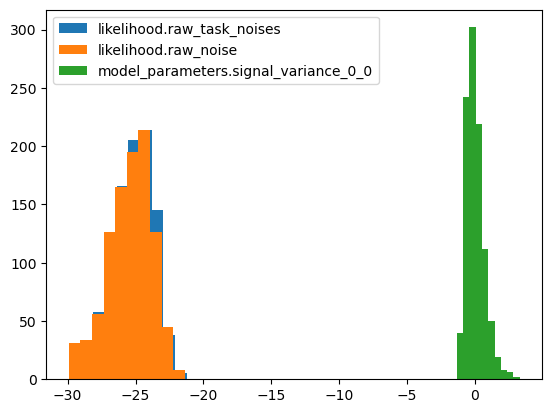

In [253]:

import pprint
pprint.pprint(MC_log["Parameter statistics"])
for param_name in MC_log['param draws dict']:
    #plt.hist(torch.nn.functional.softplus(torch.Tensor(MC_log['param draws dict'][param_name])))
    plt.hist(torch.Tensor(MC_log['param draws dict'][param_name]))
plt.legend([param[0] for param in model.named_parameters()])

print(MC_log["Parameter prior"])
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_param_distribution.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_param_distribution.tex")

/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/tikzplotlib/_axes.py:12: MatplotlibDeprecationWarning: The common_texification function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  return mpl_common_texification(string).replace("&", "\\&")


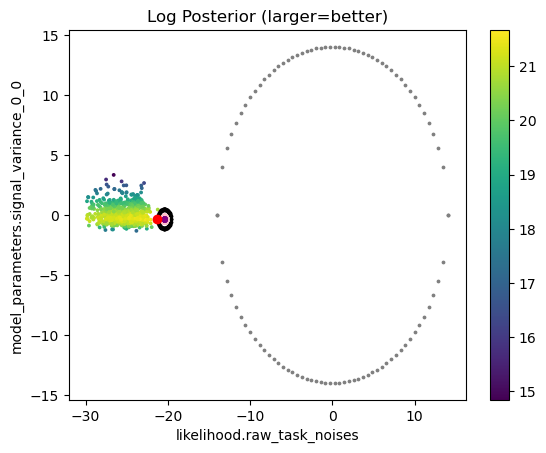

In [258]:
#
#scaling_factor = lap_log["neg MLL"]
#mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
##plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

def get_sub_tensor(tensor, num1, num2):
    sub_tensor = tensor[[num1, num2]][:, [num1, num2]]
    return sub_tensor


draw_prior=False
draw_uncorrected=False

#what_to_draw = "manual lp list" # likelihood surface 
what_to_draw = "manual post list" # posterior surface
#what_to_draw = "STAN_like_approx" # STAN likelihood surface

param_names = [param[0] for param in model.named_parameters()]

plot_param1 = "theta.1" 
plot_param2 = "theta.3" 
row_num = int(plot_param1[-1:]) - int(1) 
col_num = int(plot_param2[-1:]) - int(1)


filtered = False 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], MC_log[what_to_draw]):
    if llik > int(-100):
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
    max_index = MC_log[what_to_draw].index(max(MC_log[what_to_draw]))
    #print(f"{max(MC_log[what_to_draw])} : {MC_log['param draws dict']['theta.1'][max_index]} {MC_log['param draws dict']['theta.2'][max_index]}")
    plt.plot(MC_log['param draws dict'][plot_param1][max_index], MC_log['param draws dict'][plot_param2][max_index], "ro")
else:
    for i in range(len(MC_log['param draws dict'][plot_param1])-1):
        n, l = MC_log['param draws dict'][plot_param1][i], MC_log['param draws dict'][plot_param2][i]
        n2, l2 = MC_log['param draws dict'][plot_param1][i+int(1)], MC_log['param draws dict'][plot_param2][i+int(1)]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(MC_log['param draws dict'][plot_param1])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], c=torch.Tensor(MC_log[what_to_draw]), s=3)
    max_index = MC_log[what_to_draw].index(max(MC_log[what_to_draw]))
    plt.plot(MC_log['param draws dict'][plot_param1][max_index], MC_log['param draws dict'][plot_param2][max_index], "ro")


plt.colorbar()


mu = torch.tensor(trained_mu)[[row_num, col_num]]
K = lap_log_S["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="black", s=3)

K = lap_log_AIC["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)

K = lap_log_BIC["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="purple", s=3)


new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].flatten()[[row_num, col_num]], get_sub_tensor(MC_log["Parameter prior"]["var"], row_num, col_num))
if draw_prior or what_to_draw == "manual post list": 
    plt.scatter(new_unit_x, new_unit_y, color="gray", s=3)
K = lap_log_S["original symmetrized Hessian"]
try:
    new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
    if draw_uncorrected: 
        plt.scatter(new_unit_x, new_unit_y, color="turquoise", s=3)
except: 
    pass
plt.xlabel(param_names[row_num])
plt.ylabel(param_names[col_num])
plt.title(f"Log {'Likelihood' if 'lp' in what_to_draw else 'Posterior'} (larger=better)")

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_{'likelihood' if 'lp' in what_to_draw else 'posterior'}_surface_{param_names[row_num]}-{param_names[col_num]}.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_{'likelihood' if 'lp' in what_to_draw else 'posterior'}_surface_{param_names[row_num]}-{param_names[col_num]}.tex")

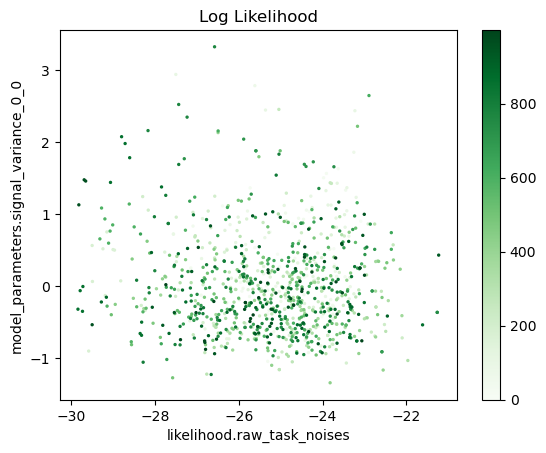

In [255]:
# Contour plot of the likelihood surface according to the explored samples
# loop to filter draws below -5000
#plot_param1 = "theta.2" 
#plot_param2 = "theta.3" 
#row_num = int(plot_param1[-1:]) - int(1) 
#col_num = int(plot_param2[-1:]) - int(1)


filtered_noise = list()
filtered_length = list()
filtered_loglike = list()
for n, l, llik in zip(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], MC_log[what_to_draw]):
    if llik > int(-5000):
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)
plt.scatter(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], c=range(len(MC_log['param draws dict'][plot_param2])), cmap="Greens", s=2)
plt.colorbar() 
## Drawing the parameter Prior
#new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].numpy().T[0][:2], MC_log["Parameter prior"]["var"].inverse()[:2, :2])
# Draw one standard deviation around the center of the distribution
#plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)
#plt.scatter(filtered_noise, filtered_length, c=filtered_loglike)

plt.xlabel(param_names[row_num])
plt.ylabel(param_names[col_num])
plt.title("Log Likelihood")

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_likelihood_path_{param_names[row_num]}-{param_names[col_num]}.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_likelihood_path_{param_names[row_num]}-{param_names[col_num]}.tex")

# Table